Running simulation for C = 10 µM...
Running simulation for C = 20 µM...
Running simulation for C = 30 µM...
Running simulation for C = 40 µM...


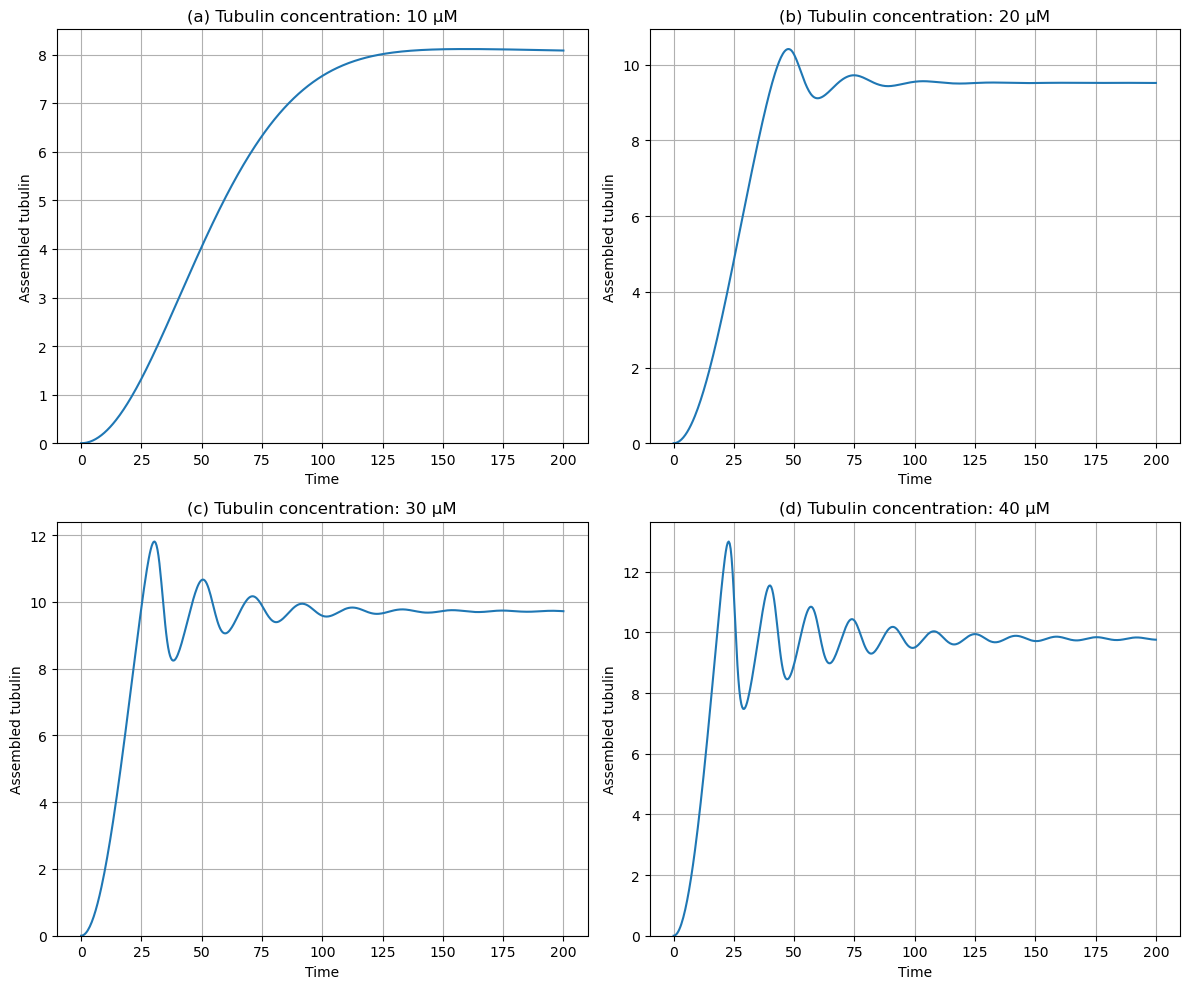

In [5]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# 1. Define Constants
R = 8.314e-3  # Universal Gas Constant in kJ/(mol*K)
kr = 2.0         # Reactivation rate in s^-1, as per the paper [cite: 151]

# 2. Define Temperature-Dependent Rate Functions
#    These functions calculate k+, kc, kn, and ki based on temperature T in Celsius.
def get_k_plus(T_C):
    """Calculates growth rate k+ based on eq. (12)""" #[cite: 128]
    T_K = T_C + 273.15 # Convert Celsius to Kelvin
    return 5.14e13 * np.exp(-75.7 / (R * T_K))

def get_kc(T_C):
    """Calculates collapse rate kc based on eq. (13)""" #[cite: 139]
    T_K = T_C + 273.15
    return 4.32e-8 * np.exp(25.9 / (R * T_K))

def get_kn(T_C):
    """Calculates nucleation rate kn based on eq. (14)""" #[cite: 143]
    T_K = T_C + 273.15
    return 8e7 * np.exp(-78.3 / (R * T_K))

def get_ki(T_C):
    """Calculates induced collapse rate ki based on eq. (21)""" #[cite: 221]
    T_K = T_C + 273.15
    return 13.0 * np.exp(-10.75 / (R * T_K))

# 3. Define the System of ODEs
#    This function is the core of the simulation, based on eq. (10) 
def microtubule_odes(t, y, C, T_C):
    """
    Defines the system of differential equations for microtubule dynamics.
    
    Args:
        t: time
        y: state vector [N, Ta, Td]
        C: total tubulin concentration
        T_C: temperature in Celsius
    
    Returns:
        A list of derivatives [dN/dt, dTa/dt, dTd/dt]
    """
    N, Ta, Td = y
    
    # Calculate Tt from the conservation law: C = Ta + Td + Tt
    Tt = C - Ta - Td #[cite: 110]
    
    # Ensure concentrations are non-negative
    Ta = max(0, Ta)
    Td = max(0, Td)
    Tt = max(0, Tt)
    N = max(0, N)

    # Get rate constants for the given temperature
    k_plus = get_k_plus(T_C)
    kc = get_kc(T_C)
    kn = get_kn(T_C)
    ki = get_ki(T_C)

    # Differential equations
    dN_dt = kn * Tt - kc * N - ki * N * Td
    dTa_dt = k_plus * N * Tt + kn * Tt - kc * Ta - ki * Ta * Td
    dTd_dt = kc * Ta + ki * Ta * Td - kr * Td
    # dT_dt is implicitly handled by the conservation law, but can be written as:
    # dTt_dt = -k_plus * N * Tt - kn * Tt + kr * Td

    return [dN_dt, dTa_dt, dTd_dt]

# 4. Set Up and Run a Simulation
def run_simulation(C_total, T_C, t_span, t_eval):
    """
    Runs a single simulation for a given tubulin concentration and temperature.
    """
    # Initial conditions as per the paper[cite: 363]:
    # Tt = C, and Ta, Td, N are all zero.
    # Note: Our ODE system takes [N, Ta, Td] as input. Tt is derived from C.
    y0 = [0, 0, 0] # Initial values for N, Ta, Td
    
    # Use solve_ivp to find the numerical solution
    solution = solve_ivp(
        fun=microtubule_odes,
        t_span=t_span,
        y0=y0,
        args=(C_total, T_C),
        dense_output=True,
        t_eval=t_eval,
        method='RK45' # Corresponds to Runge-Kutta 4(5) method
    )
    return solution

# 5. Plotting the Results
def plot_results(solution, C, T_C):
    """
    Plots the results of a simulation.
    """
    t = solution.t
    N, Ta, Td = solution.y
    Tt = C - Ta - Td

    # Replicate plots similar to those in the paper
    plt.figure(figsize=(8, 6))
    plt.plot(t, Ta, label=f'Assembled Tubulin (Ta)')
    plt.title(f'Microtubule Assembly at T={T_C}°C and C={C}µM')
    plt.xlabel('Time (s)')
    plt.ylabel('Concentration (µM)')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Main execution block to replicate Fig. 3 ---
if __name__ == '__main__':
    # Simulation parameters from the paper for Fig. 3 [cite: 354, 355]
    T_simulation = 37  # Temperature in Celsius
    concentrations = [10, 20, 30, 40] # Tubulin concentrations in µM
    t_simulation_span = [0, 200]      # Time span in seconds
    t_points = np.linspace(t_simulation_span[0], t_simulation_span[1], 500)

    # Create subplots similar to Fig. 3
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    plot_labels = ['(a)', '(b)', '(c)', '(d)']

    for i, C_sim in enumerate(concentrations):
        print(f"Running simulation for C = {C_sim} µM...")
        sim_result = run_simulation(C_sim, T_simulation, t_simulation_span, t_points)
        
        # Plotting Ta
        ax = axes[i]
        ax.plot(sim_result.t, sim_result.y[1])
        ax.set_title(f'{plot_labels[i]} Tubulin concentration: {C_sim} µM')
        ax.set_xlabel('Time')
        ax.set_ylabel('Assembled tubulin')
        ax.grid(True)
        ax.set_ylim(bottom=0)

    plt.tight_layout()
    plt.show()